<a href="https://colab.research.google.com/github/lizhieffe/llm_knowledge/blob/main/kaggle/neurips_2025_google_code_golf_championship/Eval_with_Ollama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the championship: https://www.kaggle.com/competitions/google-code-golf-2025/overview

# Public Interface

In [1]:
import dataclasses
import numpy as np


@dataclasses.dataclass
class DataPoint:
  # A list of (input, output) tuples
  train: list[tuple[np.ndarray, np.ndarray]]
  train_raw: list[dict]

  # (input, output) tuple
  test: list[tuple[np.ndarray, np.ndarray]]
  test_raw: list[dict]

# Download data and load

In [2]:
# @title Setup Kaggle credential

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [3]:
# @title Download data

%%capture


import os


base_path = "/content/google-code-golf-2025"

if not os.path.isdir(base_path):
  !pip install --user kaggle
  !kaggle competitions download -c google-code-golf-2025
  !unzip /content/google-code-golf-2025.zip -d /content/google-code-golf-2025/

In [4]:
# @title Parse the data

import json
import os

import numpy as np

print(f"Attempting to list files in: {base_path}")

# This returns a list of filename strings. It doesn't include the path.
files = os.listdir(base_path)
json_file_paths = [
    os.path.join(base_path, f) for f in files if f.endswith(".json")
]
print(f"Found {len(json_file_paths)} json files")

def extract_data_point(json_filepath: str) -> DataPoint:
  """Extract DataPoint from a json file.

  Args:
    json_filepath: The path to the json file.

  Returns:
    A DataPoint object.Ï
  """
  with open(json_filepath, "rt") as my_file:
    content = my_file.read()
    # print(content)
    json_dict = json.loads(content)
    # print(type(json_dict))

    train_val = json_dict["train"]
    all_train = [
        (np.array(it["input"]), np.array(it["output"])) for it in train_val
    ]
    train_raw = train_val

    test_val = json_dict["train"]
    all_test = [
        (np.array(it["input"]), np.array(it["output"])) for it in test_val
    ]
    test_raw = test_val

    return DataPoint(
        train=all_train, train_raw=train_raw, test=all_test, test_raw=test_raw
    )


import tqdm
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor(
    max_workers=min(512, len(json_file_paths)), thread_name_prefix="Worker"
) as executor:
  # The map() function is the key.
  # It applies 'worker_task' to each item in 'items_to_process'.
  # It automatically collects the results and returns them as an iterator.
  data_points = list(
      tqdm.tqdm(
          executor.map(extract_data_point, json_file_paths),
          total=len(json_file_paths),
      )
  )
  print(f"{len(data_points)=}")

Attempting to list files in: /content/google-code-golf-2025
Found 400 json files


100%|██████████| 400/400 [00:00<00:00, 309943.03it/s]

len(data_points)=400


# Generation libs

# Load model

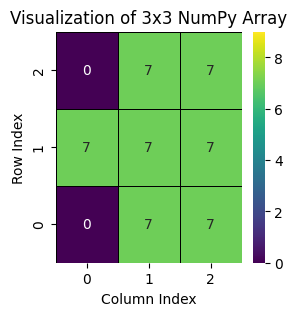

In [5]:
# @title Visualization libs

import matplotlib.pyplot as plt
import seaborn as sns # Optional, for slightly nicer colorbars and default styles

def visualize_np_array(np_array):
    """
    Visualizes a 2D NumPy array (rectangular matrix of integers between 0 and 9)
    as a heatmap.

    Args:
        np_array (np.ndarray): The NumPy array to visualize.
                               Expected shape: (rows, cols)
                               Expected values: integers between 0 and 9.
    """
    if not isinstance(np_array, np.ndarray):
        np_array = np.array(np_array)

    if np_array.ndim != 2:
        print(f"Error: Input array must be 2-dimensional, but has {np_array.ndim} dimensions.")
        return

    rows, cols = np_array.shape

    if not (1 <= rows <= 30 and 1 <= cols <= 30):
        print(f"Error: Array dimensions ({rows}x{cols}) are outside the allowed range (1x1 to 30x30).")
        return

    # Check if all values are integers between 0 and 9
    if not (np.all(np_array >= 0) and np.all(np_array <= 9) and np.all(np_array == np_array.astype(int))):
        print("Warning: Array contains values outside the 0-9 integer range. Visualization might be misleading.")
        # Attempt to cast to int to prevent issues with imshow expecting numeric data
        np_array = np_array.astype(int)

    # Set up the plot
    image_zoom_factor = 1.0 if rows <= 10 and cols <= 10 else 0.5
    plt.figure(figsize=(cols * image_zoom_factor, rows * image_zoom_factor)) # Adjust figure size dynamically for better aspect ratio

    # Use seaborn's heatmap for a more aesthetically pleasing visualization
    # 'cmap' defines the color map. 'viridis' is a good default for sequential data.
    # 'RdYlGn' (Red-Yellow-Green) or 'Greens' are also good options.
    # 'annot=True' will display the value in each cell (useful for small grids)
    # 'fmt="d"' ensures the annotation is an integer
    # 'cbar=True' shows the color bar
    # 'linewidths' and 'linecolor' add borders between cells
    sns.heatmap(np_array, annot=True, fmt="d", cmap="viridis", cbar=True,
                linewidths=0.5, linecolor='black', vmin=0, vmax=9)

    plt.title(f'Visualization of {rows}x{cols} NumPy Array')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.xticks(np.arange(cols) + 0.5, labels=np.arange(cols)) # Center ticks
    plt.yticks(np.arange(rows) + 0.5, labels=np.arange(rows)) # Center ticks
    plt.gca().invert_yaxis() # Invert y-axis to have (0,0) at top-left like typical arrays

    plt.show()

array = np.array([[0, 7, 7], [7, 7, 7], [0, 7, 7]])
visualize_np_array(array)

In [6]:
# @title Prompt Libs
SYSTEM_TURN = """You are a principle software engineer.

"""


USER_TURN_PREFIX = """You should implement a Python function to do a transformation, where the transformation is implicitly described by multiple pair of <input, output> image grids that are given. For example, the example pairs for one task might demonstrate the concept of rotation, whereas another might involve cropping and/or magnification. Your code for a given task should not only achieve the desired result across all exemplars, but also do so using the fewest possible number of characters.

A "grid" is a rectangular matrix (list of lists) of integers between 0 and 9 (inclusive). The smallest possible grid size is 1x1 and the largest is 30x30.

The function should have name "fn", one input arg named "input".

Do NOT use any external library!

Examplars:

"""


def build_prompt(data_point: DataPoint) -> list[dict[str, str]]:
  user_turn = USER_TURN_PREFIX
  user_turn += str(data_point.train_raw)

  messages = [
      {"role": "system", "content": SYSTEM_TURN},
      {"role": "user", "content": user_turn},
  ]
  return messages


# Test
conversation = build_prompt(data_points[0])
print(f"Prompt = {conversation}")

Prompt = [{'role': 'system', 'content': 'You are a principle software engineer.\n\n'}, {'role': 'user', 'content': 'You should implement a Python function to do a transformation, where the transformation is implicitly described by multiple pair of <input, output> image grids that are given. For example, the example pairs for one task might demonstrate the concept of rotation, whereas another might involve cropping and/or magnification. Your code for a given task should not only achieve the desired result across all exemplars, but also do so using the fewest possible number of characters.\n\nA "grid" is a rectangular matrix (list of lists) of integers between 0 and 9 (inclusive). The smallest possible grid size is 1x1 and the largest is 30x30.\n\nThe function should have name "fn", one input arg named "input".\n\nDo NOT use any external library!\n\nExamplars:\n\n[{\'input\': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 2, 2, 2, 0, 0], [0, 2, 0, 0, 0, 2, 0, 0], [0, 2, 0, 2, 0, 2, 0, 0], [0, 2, 0

In [7]:
# # @title Visualize GPU usage
# !pip install wandb
# import wandb
# wandb.init()

In [8]:
# @title Download Ollama
%%capture

! sudo apt-get install -y pciutils
! curl https://ollama.ai/install.sh | sh

In [9]:
# @title Ollama Libs

import os
import threading
import subprocess
import requests
import json

def server_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

def ensure_ollama_running():
  res = !ollama ps
  if res[0].startswith("Error"):
    print("Restarting Ollama")
    ollama_thread = threading.Thread(target=server_ollama)
    ollama_thread.start()

def download_ollama_model_if_necessary(model_name: str):
  ensure_ollama_running()

  list_ret = !ollama list
  downloaded = False
  for it in list_ret:
    if it.startswith(model_name):
      downloaded = True
      break

  if not downloaded:
    !ollama pull $model_name

model_name = "qwen3:32b"
model_name = "qwen3-coder:30b"
model_name = "qwen3:0.6b"
download_ollama_model_if_necessary(model_name)

ensure_ollama_running()

Restarting Ollama



In [10]:
# @title Generate Code Libs
def generate_code(
    model_name: str, data_point: DataPoint
) -> str:
  messages = build_prompt(data_point)

  url = 'http://localhost:11434/api/chat'
  payload = {
      "model": model_name,
      "temperature": 0.6,
      "stream": False,
      "messages": messages,
      "options": {
          # Set the max output tokens.
          "num_predict": 2048
      }
  }

  response = requests.post(url, json=payload)
  message_str = response.content.decode('utf-8')
  message_dict = json.loads(message_str)
  resp_str = message_dict['message']['content']

  prefix = "```python"
  suffix = "```"
  while True:
    prefix_idx = resp_str.find(prefix)
    if prefix_idx != -1:
      resp_str = resp_str[prefix_idx + len(prefix) :]
    else:
      break
  suffix_idx = resp_str.find(suffix)
  if suffix_idx != -1:
    resp_str = resp_str[: suffix_idx]
  return resp_str.strip()

# # Test
# generate_code(model_name, data_points[4])

In [11]:
# @title JIT Python execution libs

import typing
import numpy as np


def exec_and_ret(code_str: str, input: np.ndarray) -> typing.Any:
  """Execute a string of code and return the result.

  The result must be assigned to a variable named 'ret'.

  Args:
    code_str: A string of code.
    input: the input to the code.

  Returns:
    The result of the code.
  """
  loc = {}
  exec(code_str, {'input': input}, loc)
  return loc['ret']


# # Test
# code_str = """ret = 1 + 2"""
# assert 3 == exec_and_ret(code_str, input)

In [12]:
# @title Verification libs
!pip install func-timeout

from typing import Any
from func_timeout import func_timeout, FunctionTimedOut


def verify_code(
    code_str: str, data_point: DataPoint, visualize: bool = False, timeout_seconds:int = 30
) -> tuple[bool, list[Any], list[Any]]:
  """Verify the given code on its expected result."""

  # This is needed to emit the return of the execution.
  code_str += """
ret = fn(input)"""

  assert data_point.test
  inp = data_point.test[0][0].tolist()
  expected_output = data_point.test[0][1].tolist()

  # Execute the code with a timeout to prevent culprit code never returns.
  try:
    # The return value of successful_function is captured in 'result'
    output = func_timeout(timeout_seconds, exec_and_ret, args=(code_str, inp))

    if visualize:
      visualize_np_array(output)
      visualize_np_array(expected_output)

    is_match = np.allclose(np.array(output), np.array(expected_output))

    return is_match, output, expected_output
  except FunctionTimedOut:
    print(f"🛑 The function was killed after {timeout_seconds} seconds.\n")
    return False, None, expected_output


# # Test
# is_match, output, expected_output = verify_code(
#     """def fn(inp):
#       return 1""",
#     data_points[0],
# )
# print(is_match)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15077 sha256=b6f41ffdd3d76008be29a15aecfe9aaea9fb1acf4e30b1a20bf74f33cb63bd1c
  Stored in directory: /root/.cache/pip/wheels/07/e6/86/f23164d12c3134966614102db8e7956ab359faf7ffd78703ce
Successfully built func-timeout


# Run evals

In [13]:
# @title Eval Libs

from itertools import repeat
import traceback

def eval_single_dp(dp: DataPoint, model_name: str) -> bool:
  generated_code = generate_code(model_name, dp)
  try:
    is_match, _, _ = verify_code(generated_code, dp)
  except Exception as e:
    stack_trace = traceback.extract_stack()
    err_msg = f"Error: {e}. Stack trace: {stack_trace}"
    err = ValueError(err_msg)
    # print(err_msg)
    return False, err

  return is_match, None


def run_eval_loop(data_points: list[DataPoint], model_name: str) -> list[bool]:
  download_ollama_model_if_necessary(model_name)
  with concurrent.futures.ThreadPoolExecutor(
      max_workers=4, thread_name_prefix="Worker"
  ) as executor:
    eval_results = list(
        tqdm.tqdm(
            executor.map(eval_single_dp, data_points, repeat(model_name)),
            total=len(data_points),
        )
    )
    return eval_results

In [27]:
models = {
    # Works
    # "QWEN3_CODER_30B": "qwen3-coder:30b", # 18GB disk space
    # "QWEN3_06B": "qwen3:0.6b",            # 522MB disk space
    # "QWEN2P5_CODER_0P5B": "qwen2.5-coder:0.5b",
    # "QWEN2P5_CODER_1P5B": "qwen2.5-coder:1.5b",
    # "QWEN2P5_CODER_7B": "qwen2.5-coder:7b",
    # "QWEN2P5_CODER_14B": "qwen2.5-coder:14b",
    # "QWEN2P5_CODER_32B": "qwen2.5-coder:32b",   # 19GB disk space
    # "DS_CODER_1P3B": "deepseek-coder:1.3b",
    # "DS_CODER_6P7B": "deepseek-coder:6.7b",
    # "DS_CODER_33B": "deepseek-coder:33b",
    "QWEN3_CODER_30B_LATEST": "hf.co/unsloth/Qwen3-Coder-30B-A3B-Instruct-GGUF",   # 18GB disk space
    # "QWEN3_CODER_30B_Q5_K_S": "hf.co/unsloth/Qwen3-Coder-30B-A3B-Instruct-GGUF:Q5_K_S",   # 21GB disk space

    # Not work
}

eval_dps = data_points

model_eval_results = dict()
for model_name, model_name in models.items():
  print(f"Evaluating **{model_name}** ...")
  eval_results = run_eval_loop(eval_dps, model_name)
  model_eval_results[model_name] = eval_results

  is_matches = [result[0] for result in eval_results]
  errors = [result[1] for result in eval_results]

  num_valid_code = errors.count(None)
  num_invalid_code = errors.count(not None)
  num_correct_code = sum(is_matches)
  num_incorrect_code = num_valid_code - num_correct_code

  print(
      f"Valid code rate = {num_valid_code / len(eval_results):.2f}"
  )
  print(
      f"Correct code rate ="
      f" {num_correct_code / len(eval_results):.2f}"
  )
  print("=" * 80)
  print("=" * 80)
  print("=" * 80)

Evaluating **hf.co/unsloth/Qwen3-Coder-30B-A3B-Instruct-GGUF** ...


  4%|▍         | 17/400 [09:30<3:34:20, 33.58s/it]


KeyboardInterrupt: 

# Result summary


Evaluating **qwen2.5-coder:0.5b** ...
100%|██████████| 400/400 [1:12:40<00:00, 10.90s/it]
Valid code rate = 0.04
Correct code rate = 0.00
================================================================================
================================================================================
================================================================================
Evaluating **qwen2.5-coder:1.5b** ...
100%|██████████| 400/400 [40:43<00:00,  6.11s/it]
Valid code rate = 0.15
Correct code rate = 0.00
================================================================================
================================================================================
================================================================================
Evaluating **qwen2.5-coder:7b** ...
100%|██████████| 400/400 [46:58<00:00,  7.05s/it]
Valid code rate = 0.34
Correct code rate = 0.01
================================================================================
================================================================================
================================================================================
Evaluating **qwen2.5-coder:14b** ...
100%|██████████| 400/400 [1:54:58<00:00, 17.25s/it]
Valid code rate = 0.39
Correct code rate = 0.03
================================================================================
================================================================================
================================================================================
Evaluating **qwen3-coder:30b** ...
100%|██████████| 400/400 [4:49:12<00:00, 43.38s/it]
Valid code rate = 0.61
Correct code rate = 0.11
================================================================================
================================================================================
================================================================================


Evaluating **deepseek-coder:1.3b** ...
100%|██████████| 400/400 [45:09<00:00,  6.77s/it]Valid code rate = 0.00
Correct code rate = 0.00
================================================================================
================================================================================
================================================================================
Evaluating **deepseek-coder:6.7b** ...
100%|██████████| 400/400 [1:13:30<00:00, 11.03s/it]
Valid code rate = 0.19
Correct code rate = 0.01
================================================================================
================================================================================
================================================================================
Evaluating **deepseek-coder:33b** ...
100%|██████████| 400/400 [6:04:08<00:00, 54.62s/it]
Valid code rate = 0.20
Correct code rate = 0.05
================================================================================
================================================================================
================================================================================